### Tutorial 2. Convolution

In [2]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

In [3]:
# Irreps for input and output features
irreps_input = o3.Irreps("10x0e + 10x1e")
irreps_output = o3.Irreps("20x0e + 10x1e")

In [4]:
# create node positions 
num_nodes = 100
pos = torch.randn(num_nodes, 3) # random node positions

# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors = num_nodes - 1)

print(edge_src.shape)

edge_vec = pos[edge_dst] - pos[edge_src]

# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([3678])


36.78

In [5]:
f_in = irreps_input.randn(num_nodes, -1)

In [7]:
f_in.pow(2).mean() # should be close to 1

tensor(1.0019)

In [8]:
# Initialize the spherical harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)
print(irreps_sh)

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
# normalize = True insured that x is divided by |x| befire computing the sh

sh.pow(2).mean() # should be close to 1

1x0e+1x1o+1x2e


tensor(1.)

/Users/temporary/Documents/GitHub/pytorch-intel-mps/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


FullyConnectedTensorProduct(10x0e+10x1e x 1x0e+1x1o+1x2e -> 20x0e+10x1e | 400 paths | 400 weights) needs 400 weights


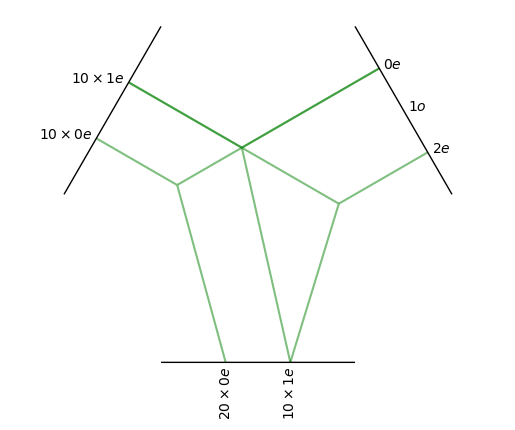

In [10]:
# tensor product part
tp = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights = False)

print(f'{tp} needs {tp.weight_numel} weights')

tp.visualize();

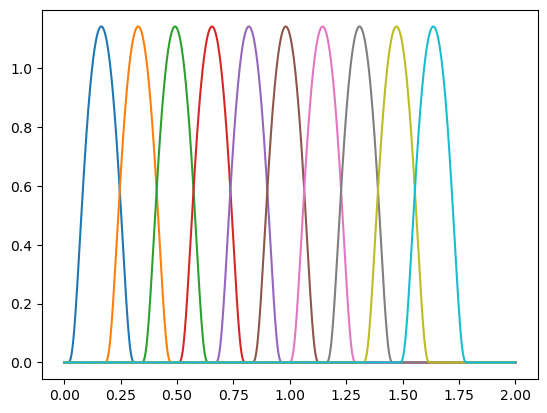

In [13]:
# embeding of the radial distance

num_basis = 10

x = torch.linspace(0.0, 2.0, 1000)
y = soft_one_hot_linspace(
    x,
    start = 0.0,
    end = max_radius,
    number = num_basis,
    basis = 'smooth_finite',
    cutoff = True,
)

plt.plot(x, y);

In [15]:
edge_length_enbedding = soft_one_hot_linspace(
    edge_vec.norm(dim = 1),
    start = 0.0,
    end = max_radius,
    number= num_basis,
    basis = 'smooth_finite',
    cutoff = True
)

edge_length_enbedding = edge_length_enbedding.mul(num_basis**0.5)

print(edge_length_enbedding.shape)
edge_length_enbedding.pow(2).mean() # the second moment

torch.Size([3678, 10])


tensor(0.8915)

In [18]:
# Feeding the embedding to mlp
fc = nn.FullyConnectedNet([num_basis, 16, tp.weight_numel], torch.relu)
weight = fc(edge_length_enbedding)

print(weight.shape)
print(len(edge_src), tp.weight_numel)


# For a proper normalization, the weights also need to be mean 0
print(weight.mean(), weight.std()) # should be close to 0 and 1

torch.Size([3678, 400])
3678 400
tensor(-0.0012, grad_fn=<MeanBackward0>) tensor(0.7728, grad_fn=<StdBackward0>)


In [19]:
# lift f to edges (just mapping all edges to its source node)

summand = tp(f_in[edge_src], sh, weight)

print(summand.shape)
print(summand.pow(2).mean()) # should be close to 1

torch.Size([3678, 50])
tensor(0.6091, grad_fn=<MeanBackward0>)


In [20]:
# computing out feature vector
f_out = scatter(summand, edge_dst, dim = 0, dim_size = num_nodes)

f_out = f_out.div(num_neighbors**0.5)

f_out.pow(2).mean() # should be close to 1

tensor(0.5780, grad_fn=<MeanBackward0>)

In [23]:
# put everything into conv layer
def conv(f_in, pos):
    edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
    edge_vec = pos[edge_dst] - pos[edge_src]
    
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim = 1), 0.0, max_radius, num_basis, basis = 'smooth_finite', cutoff = True).mul(num_basis**0.5)
    
    return scatter(tp(f_in[edge_src], sh, fc(emb)), edge_dst, dim = 0, dim_size= num_nodes).div(num_neighbors**0.5)

In [26]:
# Check the equivariance
rot = o3.rand_matrix()
D_in = irreps_input.D_from_matrix(rot)
D_out = irreps_output.D_from_matrix(rot)

# rotate before
f_before = conv(f_in @ D_in.T, pos @ rot.T)

# rotate after
f_after = conv(f_in, pos) @ D_out.T

torch.allclose(f_before, f_after, rtol = 1e-4, atol = 1e-4)

True

In [30]:
import time
# Check the timing
wall = time.perf_counter()

edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=len(pos) - 1)
edge_vec = pos[edge_dst] - pos[edge_src]
print("Graph gen"); print(time.perf_counter() - wall); wall = time.perf_counter()

sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
print("Gen of spherical harm"); print(time.perf_counter() - wall); wall = time.perf_counter()

emb = soft_one_hot_linspace(edge_vec.norm(dim = 1), 0.0, max_radius, num_basis, basis = 'smooth_finite', cutoff = True).mul(num_basis**0.5)
print("Embedding"); print(time.perf_counter() - wall); wall = time.perf_counter()

weight = fc(emb)
print("FC"); print(time.perf_counter() - wall); wall = time.perf_counter()

summand = tp(f_in[edge_src], sh, weight)
print("Tensor product"); print(time.perf_counter() - wall); wall = time.perf_counter()

scatter(summand, edge_dst, dim = 0, dim_size = num_nodes).div(num_neighbors**0.5)
print("Summing over"); print(time.perf_counter() - wall); wall = time.perf_counter()

Graph gen
0.0018157399990741396
Gen of spherical harm
0.0016743369997129776
Embedding
0.00318902900107787
FC
0.0035485670014168136
Tensor product
0.009063723000508617
Summing over
0.0023591940007463563


### Tutorial 3. Normalization

In [34]:
# component normalization <x^2> = 1
print(torch.rand(10))

# norm normalization ||x|| = 1
print(torch.rand(10) / 10 ** 0.5)

tensor([0.1758, 0.5139, 0.8533, 0.5818, 0.9249, 0.7385, 0.0574, 0.6382, 0.7904,
        0.2311])
tensor([0.2966, 0.0571, 0.0315, 0.2777, 0.2997, 0.0183, 0.1587, 0.2926, 0.1234,
        0.0932])


In [33]:
from e3nn.util.test import assert_normalized
from e3nn import o3
assert_normalized(o3.Linear("10x0e", "10x0e"))

AssertionError: < x_i^2 > !~= 1.000000 for output irrep #0, 10x0e.Max componentwise error: 0.137567